# Playground to implement W&B as well as start hyperparameter-tuning

# WanDB

In [1]:
#%pip install wandb

In [1]:
import subprocess
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import os

In [2]:
subprocess.call(['wandb', 'login', '4e8d3dcb1584ad129b3b49ccc34f65b20116ae54'])

0

In [3]:
wandb.init(project='precursor_charge_prediction_new')

wandb: Currently logged in as: nkopp (team-bioinf). Use `wandb login --relogin` to force relogin


## Setup

In [ ]:
#%pip install seaborn

In [4]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
import keras

In [5]:
train_datapath = ["data/"+file for file in os.listdir('data') if file.endswith(".parquet")][0]
batch_size = 32

# Dataset batches + split

In [6]:
import re

def one_hot_precursor(int_value, charges=[1,2,3,4,5,6]):
    """
    One-hot encodes the precursor charge
    :param df: dataframe
    :param max_charge_included: int
    :return: dataframe
    """
    one_hot = [1 if x == int_value else 0 for x in charges]

    return one_hot

In [8]:
file_list = ["data/"+file for file in os.listdir('data') if file.endswith('.parquet')]
print(file_list[0])

data/Thermo_SRM_Pool_meta_data.parquet


### import parquet files, drop all columns we dont need for training, one-hot encode precursor charge, translate sequence

In [9]:
batches_parquet = dict()
counter = 0
for file in file_list:
    df = pd.read_parquet(file, engine='fastparquet')
    # drop all columns we dont need for training
    for column in df.columns:
        if column not in ["modified_sequence","precursor_intensity", "precursor_charge"]:
            df.drop(column, axis=1, inplace=True)
    charge_ranges = [1, 2, 3, 4, 5, 6] # TODO SET RANGES
    df = df[df["precursor_charge"].isin(charge_ranges)] # remove 7+ charge states // only take charge states 2,3,4
    df = df.dropna(subset=['precursor_intensity']) # drop rows with no precursor intensity
    batches_parquet[file] = df
    counter += 1
    #if counter > 1:
    #    break # TODO REMOVE BREAK FOR FIRST FILE IN LIST

In [10]:
vocabulary = []
vocabulary+=list('XACDEFGHIKLMNPQRSTVWY')
max_len_seq = 0

for df in batches_parquet.values():
    if max_len_seq < df['modified_sequence'].str.len().max():
        max_len_seq = df['modified_sequence'].str.len().max()
    annotations = re.findall(r'(\w\[UNIMOD:\d+\])', ' '.join(df['modified_sequence']))
    #annotations = re.findall(r'[A-Z]\[[^\]]*\]|.', ' '.join(df['modified_sequence']))
    for item in annotations:
        if item not in vocabulary:
                vocabulary.append(item)

In [87]:
print(vocabulary)
voc_len = len(vocabulary)
voc_len

['X', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'C[UNIMOD:4]', 'M[UNIMOD:35]']


23

In [12]:
print(seq_translator('AAC[UNIMOD:4]LLVAW', print_result=False))

[1, 1, 21, 10, 10, 18, 1, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
num_classes = len(charge_ranges)
class_names = charge_ranges

In [14]:
batches_parquet[file_list[0]].head()

,modified_sequence,precursor_charge,precursor_intensity
0,LPGSLETYVEQEQGENANDR,2,29525630.0
1,HGSLQEYLQNDTGSK,2,13188580.0
2,VEEEEEINSELTAR,2,20663460.0
3,LPGSLETYVEQEQGENANDR,2,19884630.0
4,NSSTAEINETTTSSTDFLAR,2,12804420.0


In [15]:
file_list

['data/Thermo_SRM_Pool_meta_data.parquet',
 'data/TUM_aspn_meta_data.parquet',
 'data/TUM_first_pool_meta_data.parquet',
 'data/TUM_HLA2_meta_data.parquet',
 'data/TUM_HLA_meta_data.parquet',
 'data/TUM_isoform_meta_data.parquet',
 'data/TUM_lysn_meta_data.parquet',
 'data/TUM_missing_first_meta_data.parquet',
 'data/TUM_proteo_TMT_meta_data.parquet',
 'data/TUM_second_addon_meta_data.parquet',
 'data/TUM_second_pool_meta_data.parquet',
 'data/TUM_third_pool_meta_data.parquet']

In [16]:
batches_parquet[file_list[0]]["precursor_charge"].value_counts()

2    4331294
3    1523398
4     115577
5       2723
1       1022
6        143
Name: precursor_charge, dtype: int64

# Normalisieren:

In [17]:
def normalize_for_most_abundant(df_charge_list, df_intensity_list):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        charge_dict[i] = []
        charge_dict[i].append(df_intensity_list[index])

    # Normalize the precursor intensity based on the most abundant precursor intensity
    for key, value in charge_dict.items():
        if len(value) > 1:
         charge_dict[key] = sum(value) - min(value) / (max(value) - min(value))

    # convert list of one float to float values
    charge_dict = {key: value[0] for key, value in charge_dict.items()}

    return charge_dict

In [18]:
def get_most_abundant(df_charge_list, df_intensity_list, distributions=False):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        if i not in charge_dict:
            charge_dict[i] = df_intensity_list[index]
        else:
            charge_dict[i] += df_intensity_list[index]
    if distributions:
        #print(charge_dict)
        return charge_dict
    else:
        return max(charge_dict, key=charge_dict.get)


In [19]:
# load all parquets into df
df_dict = dict()
for file in file_list:
    df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()

C:\Users\micro\AppData\Local\Temp\ipykernel_27784\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppData\Local\Temp\ipykernel_27784\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppData\Local\Temp\ipykernel_27784\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\A

# init merged_df

In [95]:
merged_df = pd.concat(list(df_dict.values())).groupby("modified_sequence")["precursor_charge", "precursor_intensity"].sum().reset_index()

C:\Users\micro\AppData\Local\Temp\ipykernel_27784\1215419649.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merged_df = pd.concat(list(df_dict.values())).groupby("modified_sequence")["precursor_charge", "precursor_intensity"].sum().reset_index()


In [96]:
merged_df['seq_len_prepadding'] = merged_df['modified_sequence'].apply(lambda x: len(x))

In [97]:
len_counts = merged_df['seq_len_prepadding'].value_counts()
seq_too_long = len_counts[len_counts <= 10]
seq_too_long

87     9
82     8
85     7
89     6
90     5
107    4
97     4
95     4
92     4
83     3
86     3
98     3
91     2
84     2
93     2
88     2
96     2
110    2
105    1
104    1
102    1
94     1
103    1
115    1
99     1
125    1
108    1
Name: seq_len_prepadding, dtype: int64

In [98]:
seq_lengths = merged_df['seq_len_prepadding'].value_counts().index.values, merged_df['seq_len_prepadding'].value_counts().values
seq_too_long = pd.DataFrame()
seq_too_long['seq_len'] = seq_lengths[0][seq_lengths[0] >= 50]
seq_too_long['count'] = seq_lengths[1][seq_lengths[0] >= 50]
seq_too_long

,seq_len,count
0,50,1087
1,51,764
2,52,595
3,53,426
4,56,385
5,57,385
6,55,382
7,58,373
8,54,366
9,59,290


In [99]:
# give smallest seq_len when count <= 100
seq_len_cutoff_df = seq_too_long[seq_too_long['count'] <= 100]
seq_len_cutoff = min(seq_len_cutoff_df['seq_len'])

In [100]:
seq_len_cutoff

64

In [101]:
# reapply max len
max_len_seq = seq_len_cutoff-1

In [102]:
def seq_translator(sequence, dictionary=vocabulary, max_len=max_len_seq, print_result=False):
    """
    Translates a sequence into a vector of integers
    :param print_result:
    :param max_len:
    :param sequence: string
    :param dictionary: dictionary
    :return: list
    """
    pattern = r'[A-Z]\[[^\]]*\]|.' # regex pattern to match amino acids and modifications
    #pattern = r'(\w\[UNIMOD:\d+\])' # regex pattern to match amino acids and modifications

    result = [match for match in re.findall(pattern, sequence)]

    # Fill the list with "X" characters until it reaches a length of 40
    result += ['X'] * (max_len - len(result))
    if print_result:
        print(result)

    aa_dictionary = dict()
    for index, aa in enumerate(dictionary):
        aa_dictionary[aa] = index

    return [aa_dictionary[aa] for aa in result]

In [110]:
delete_a_row = True
if delete_a_row:
# delete row if seq_len_prepadding larger or equal to seq_len_cutoff
    index_to_delete_seq = merged_df[merged_df['seq_len_prepadding'] >= seq_len_cutoff].index
    merged_df.drop(index_to_delete_seq, inplace=True)

In [114]:
# output all sequences with seq_len_prepadding >= 50
merged_df[merged_df['seq_len_prepadding'] >= seq_len_cutoff]

,modified_sequence,precursor_charge,precursor_intensity,seq_len_prepadding


In [115]:
merged_df['normalized'] = merged_df.apply(lambda x: normalize_for_most_abundant(x["precursor_charge"], x["precursor_intensity"]), axis=1)

In [116]:
merged_df['pre_normalization'] = merged_df.apply(lambda x: get_most_abundant(x["precursor_charge"], x["precursor_intensity"], True), axis=1)

In [117]:
# return key for max value in dict
merged_df['most_abundant_charge'] = merged_df['normalized'].apply(lambda x: max(x, key=x.get))

In [118]:
merged_df["most_abundant_charge_vector"] = merged_df["most_abundant_charge"].apply(one_hot_precursor, args=(charge_ranges,))

In [119]:
merged_df["modified_sequence_vector"] = merged_df["modified_sequence"].apply(seq_translator)

In [120]:
merged_df.head(11)

,modified_sequence,precursor_charge,precursor_intensity,seq_len_prepadding,normalized,pre_normalization,most_abundant_charge,most_abundant_charge_vector,modified_sequence_vector
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...",22,"{2: 588796.3, 3: 4654280.0, 1: 791369.9}","{2: 1043873837.3, 3: 30130627.0, 1: 1582739.8}",3,"[0, 0, 1, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",21,{2: 303307.5},{2: 107202221.5},2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",22,{2: 3067981.0},{2: 12271924.0},2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[11913300.0, 11913300.0, 11913300.0, 11913300....",26,"{2: 8093413.0, 3: 1414907.0}","{2: 148659685.0, 3: 4244721.0}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...",15,{1: 1124818.0},{1: 546950229.4000001},1,"[1, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ..."
5,AAAAAAAAAAAAAAGAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[853119.3, 4332449.0, 3688977.0, 3469130.0, 33...",17,{1: 679216.3},{1: 52634067.9},1,"[1, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ..."
6,AAAAAAAAAAAAAAGGLALGLH,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[33516080.0, 33516080.0, 8522070.0, 4549188.0,...",22,{2: 365943.3},{2: 6848110396.300002},2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ..."
7,AAAAAAAAAAAAAAVTSGV,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[4576179.0, 3336856.0, 4954145.0, 4317804.0, 3...",19,"{2: 14611910.0, 1: 1211272.0}","{2: 225462597.40000004, 1: 5840742.2}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 18,..."
8,AAAAAAAAAAAAAGAG,"[1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, ...","[1233316.0, 2671238.0, 11414430.0, 13683660.0,...",16,"{1: 1879604.0, 2: 2586197.0}","{1: 349665943.5, 2: 228379326.3}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, ..."
9,AAAAAAAAAAAAAK,"[1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, ...","[2540360.0, 31115000.0, 31115000.0, 70371250.0...",14,"{1: 8372130.0, 2: 15308280.0}","{1: 99493666.2, 2: 6574531120.0}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 0, ..."


In [121]:
len(merged_df)

830820

In [53]:
merged_df["most_abundant_charge"].value_counts()

2    452544
3    259972
4     65966
1     41352
5      9069
6      1917
Name: most_abundant_charge, dtype: int64

In [ ]:
#get the

In [30]:
print(file_list[0])
look_up_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
len(look_up_df)

data/Thermo_SRM_Pool_meta_data.parquet


C:\Users\micro\AppData\Local\Temp\ipykernel_26372\365009680.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  look_up_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()


70445

# Dataset preprocessing: Conv2d

In [36]:
# proof of concept
# we have a sequence ABC with:
list_a = [1,2,1,2,1,2,1,2,1,2] # charge states for "ABC" sequence with multiple appearances
list_b = [111,21,311,41,51,611111,71,81,91111111,1011] # intensities for "ABC" sequence in each charge state
print("most abundant: ", get_most_abundant(list_a, list_b, True))

most abundant:  {1: 91111655, 2: 612265}


In [123]:
main_ds = np.array(merged_df["modified_sequence_vector"]) # to list
main_ds_labels = np.array(merged_df['most_abundant_charge_vector'])

In [124]:
# Create an instance of StratifiedShuffleSplit
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Perform the split train+val and test
trainval_indicies, test_indicies = next(sss1.split(main_ds, main_ds_labels))

trainval_ds, trainval_labels = main_ds[trainval_indicies], main_ds_labels[trainval_indicies]
test_ds, test_labels = main_ds[test_indicies], main_ds_labels[test_indicies]

In [125]:
# Perform the split train and val
train_indicies, val_indicies = next(sss2.split(trainval_ds, trainval_labels))

train_ds, train_labels = trainval_ds[train_indicies], trainval_labels[train_indicies]
val_ds, val_labels = trainval_ds[val_indicies], trainval_labels[val_indicies]


charges = [1,2,3,4,5,6] # TODO SELECT CLASSES
num_classes = len(charges)

### Conv2d Model

In [71]:
train_ds = [np.reshape(np.array(x), (1, max_len_seq, 1)) for x in train_ds]
val_ds = [np.reshape(np.array(x), (1, max_len_seq, 1)) for x in val_ds]
test_ds = [np.reshape(np.array(x), (1, max_len_seq, 1)) for x in test_ds]

In [72]:
train_ds[0]

array([[[21],
        [ 4],
        [ 6],
        [ 5],
        [ 4],
        [10],
        [ 7],
        [ 5],
        [19],
        [15],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0]]])

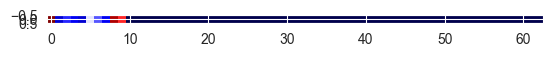

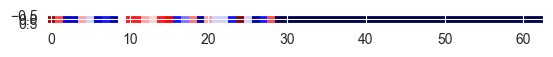

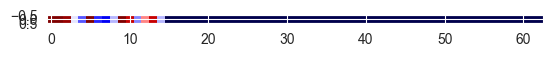

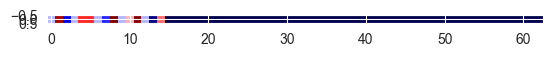

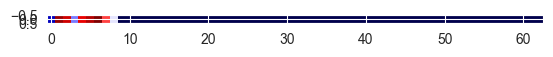

In [73]:
from matplotlib import pyplot as plt
for i in range(5):
    plt.imshow(train_ds[i], interpolation='nearest', cmap='seismic') # TODO CUSTOM COLORS FOR AA
    plt.show()

In [ ]:
train_ds = tf.convert_to_tensor(train_ds)
val_ds = tf.convert_to_tensor(val_ds)

In [ ]:
train_ds_labels = [np.array(x) for x in train_ds_labels]
val_ds_labels = [np.array(x) for x in val_ds_labels]

In [ ]:
train_ds_labels = tf.convert_to_tensor(train_ds_labels)
val_ds_labels = tf.convert_to_tensor(val_ds_labels)

In [ ]:
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA = Input(shape=train_ds.shape[1:])
# the first branch operates on the first input
x = Model(inputs=inputA, outputs=inputA)
# the second branch operates on the second input
y = Rescaling(scale=1./100)(inputA) # for dictionary of 2000 words (X = 0, aa 1-20 in 100 steps)
#y = Embedding(input_dim=2000, output_dim=3, input_length=50)(inputB)
y = Conv2D(filters=128, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
#y = Conv2D(filters=128, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
y = Flatten()(y)
y = Dense(210, activation="relu")(y)
# combine the output of the two branches
#z = Flatten()(combined)
z = Dense(num_classes, activation="softmax")(y)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input], outputs=z)

In [ ]:
model.summary()

In [ ]:
# plot model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
checkpoint_callback = ModelCheckpoint('precursor_charge_prediction_model_v1/cce_wo7_allSequences.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
#steps_per_epoch = train_ds_b.shape[0] // 256

In [ ]:
# Train the model
# X_train, X_test, y_train, y_test
history = model.fit(train_ds, train_ds_labels, epochs=120, batch_size=4096, validation_data=(val_ds, val_ds_labels), callbacks=[checkpoint_callback, early_stopping, WandbCallback()]) #WandbCallback()

In [ ]:
# Access the loss, validation loss, and accuracy from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
model.save('precursor_charge_prediction_conv2d_model/big_conv2d_model.h5')

# Embedding model test:

In [168]:
# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [182]:
df1 = merged_df.sample(frac = 0.1, random_state = 42)
test_ds_embed = np.array(df1['modified_sequence_vector'])
test_labels_embed = np.array(df1['most_abundant_charge_vector'])

df2 = merged_df.drop(df1.index)
trainval_ds_embed = np.array(df2['modified_sequence_vector'])
trainval_labels_embed = np.array(df2['most_abundant_charge_vector'])

In [183]:
# Perform the split train and val
train_indicies_embed, val_indicies_embed = next(sss.split(trainval_ds_embed, trainval_labels_embed))

In [184]:
train_ds_embed, train_labels_embed = trainval_ds_embed[train_indicies_embed], trainval_labels_embed[train_indicies_embed]
val_ds_embed, val_labels_embed = trainval_ds_embed[val_indicies_embed], trainval_labels_embed[val_indicies_embed]


charges = [1,2,3,4,5,6] # TODO SELECT CLASSES
num_classes = len(charges)

In [185]:
train_ds_embed  = [np.array(x) for x in train_ds_embed]
val_ds_embed = [np.array(x) for x in val_ds_embed]
test_ds_embed = [np.array(x) for x in test_ds_embed]

In [186]:
train_labels_embed = [np.array(x) for x in train_labels_embed]
val_labels_embed = [np.array(x) for x in val_labels_embed]
test_labels_embed = [np.array(x) for x in test_labels_embed]

In [187]:
train_ds_embed = tf.convert_to_tensor(train_ds_embed)
val_ds_embed = tf.convert_to_tensor(val_ds_embed)
train_labels_embed = tf.convert_to_tensor(train_labels_embed)
val_labels_embed = tf.convert_to_tensor(val_labels_embed)

test_ds_embed = tf.convert_to_tensor(test_ds_embed)
test_labels_embed = tf.convert_to_tensor(test_labels_embed)

In [188]:
train_ds_embed[0]

<tf.Tensor: shape=(63,), dtype=int32, numpy=
array([18, 18, 16,  1,  6, 13, 19, 16, 16,  4,  9,  1,  4, 11, 12,  8, 10,
        4,  8, 12,  4, 17, 10, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])>

In [190]:
wandb.init(project='precursor_charge_prediction_new')

categorical_accuracy,▁▃▄▅▅▆▆▇▇▇████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁▂▃▄▅▆▆▇▇▇████████████████████
val_loss,█▇▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,29
best_val_loss,0.49894
categorical_accuracy,0.78707
epoch,29
loss,0.49829
val_categorical_accuracy,0.78575


In [189]:
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA_embed = Input(shape=train_ds_embed[0].shape)
# the first branch operates on the first input
x = Model(inputs=inputA_embed, outputs=inputA_embed)
y = Embedding(input_dim=voc_len, output_dim=max_len_seq, input_length=max_len_seq)(inputA_embed)
y = Flatten()(y)
y = Dense(max_len_seq, activation="relu")(y)
z = Dense(num_classes, activation="softmax")(y)
# our model will accept the inputs of the two branches and
# then output a single value
model_embed = Model(inputs=[x.input], outputs=z)

In [191]:
model_embed.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 63)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 63, 63)            1449      
                                                                 
 flatten_4 (Flatten)         (None, 3969)              0         
                                                                 
 dense_8 (Dense)             (None, 63)                250110    
                                                                 
 dense_9 (Dense)             (None, 6)                 384       
                                                                 
Total params: 251,943
Trainable params: 251,943
Non-trainable params: 0
_________________________________________________________________


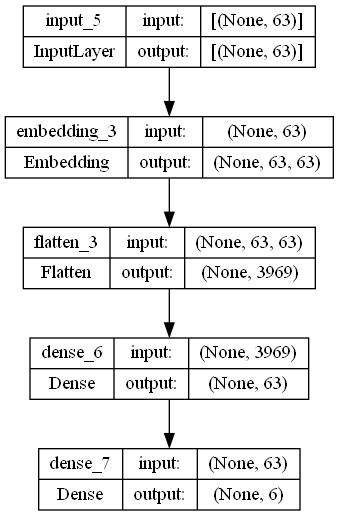

In [139]:
# plot model
tf.keras.utils.plot_model(model_embed, show_shapes=True, show_layer_names=True)

In [192]:
# Compile the model
model_embed.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['categorical_accuracy'])

In [193]:
checkpoint_callback_embed = ModelCheckpoint('precursor_charge_prediction_model_embed/embed.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping_embed = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [194]:
# sanity check for loss
np.log2(6)

2.584962500721156

In [195]:
# Train the model
# X_train, X_test, y_train, y_test
history_embed = model_embed.fit(train_ds_embed, train_labels_embed, epochs=30, batch_size=4096, validation_data=(val_ds_embed, val_labels_embed), callbacks=[checkpoint_callback_embed, early_stopping_embed, WandbCallback()]) #WandbCallback()

Epoch 1/30
146/147 [============================>.] - ETA: 0s - loss: 1.1609 - categorical_accuracy: 0.5664WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 14s 95ms/step - loss: 1.1609 - categorical_accuracy: 0.5664 - val_loss: 0.9842 - val_categorical_accuracy: 0.6038
Epoch 2/30
146/147 [============================>.] - ETA: 0s - loss: 0.9371 - categorical_accuracy: 0.6169WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 86ms/step - loss: 0.9371 - categorical_accuracy: 0.6169 - val_loss: 0.8919 - val_categorical_accuracy: 0.6313
Epoch 3/30
146/147 [============================>.] - ETA: 0s - loss: 0.8431 - categorical_accuracy: 0.6549WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 85ms/step - loss: 0.8431 - categorical_accuracy: 0.6550 - val_loss: 0.7918 - val_categorical_accuracy: 0.6791
Epoch 4/30
146/147 [============================>.] - ETA: 0s - loss: 0.7456 - categorical_accuracy: 0.6919WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 86ms/step - loss: 0.7456 - categorical_accuracy: 0.6919 - val_loss: 0.7005 - val_categorical_accuracy: 0.7074
Epoch 5/30
146/147 [============================>.] - ETA: 0s - loss: 0.6659 - categorical_accuracy: 0.7165WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.6659 - categorical_accuracy: 0.7165 - val_loss: 0.6352 - val_categorical_accuracy: 0.7208
Epoch 6/30
146/147 [============================>.] - ETA: 0s - loss: 0.6130 - categorical_accuracy: 0.7381WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 91ms/step - loss: 0.6130 - categorical_accuracy: 0.7381 - val_loss: 0.5934 - val_categorical_accuracy: 0.7509
Epoch 7/30
146/147 [============================>.] - ETA: 0s - loss: 0.5799 - categorical_accuracy: 0.7567WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 89ms/step - loss: 0.5799 - categorical_accuracy: 0.7567 - val_loss: 0.5673 - val_categorical_accuracy: 0.7629
Epoch 8/30
146/147 [============================>.] - ETA: 0s - loss: 0.5590 - categorical_accuracy: 0.7652WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 14s 94ms/step - loss: 0.5590 - categorical_accuracy: 0.7652 - val_loss: 0.5510 - val_categorical_accuracy: 0.7703
Epoch 9/30
146/147 [============================>.] - ETA: 0s - loss: 0.5460 - categorical_accuracy: 0.7700WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 87ms/step - loss: 0.5460 - categorical_accuracy: 0.7700 - val_loss: 0.5407 - val_categorical_accuracy: 0.7728
Epoch 10/30
146/147 [============================>.] - ETA: 0s - loss: 0.5369 - categorical_accuracy: 0.7734WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.5369 - categorical_accuracy: 0.7734 - val_loss: 0.5342 - val_categorical_accuracy: 0.7734
Epoch 11/30
146/147 [============================>.] - ETA: 0s - loss: 0.5306 - categorical_accuracy: 0.7757WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 85ms/step - loss: 0.5306 - categorical_accuracy: 0.7757 - val_loss: 0.5280 - val_categorical_accuracy: 0.7781
Epoch 12/30
146/147 [============================>.] - ETA: 0s - loss: 0.5255 - categorical_accuracy: 0.7775WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 89ms/step - loss: 0.5255 - categorical_accuracy: 0.7775 - val_loss: 0.5235 - val_categorical_accuracy: 0.7783
Epoch 13/30
146/147 [============================>.] - ETA: 0s - loss: 0.5218 - categorical_accuracy: 0.7790WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 89ms/step - loss: 0.5218 - categorical_accuracy: 0.7790 - val_loss: 0.5213 - val_categorical_accuracy: 0.7799
Epoch 14/30
146/147 [============================>.] - ETA: 0s - loss: 0.5190 - categorical_accuracy: 0.7799WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 86ms/step - loss: 0.5190 - categorical_accuracy: 0.7799 - val_loss: 0.5186 - val_categorical_accuracy: 0.7814
Epoch 15/30
146/147 [============================>.] - ETA: 0s - loss: 0.5169 - categorical_accuracy: 0.7805WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 86ms/step - loss: 0.5169 - categorical_accuracy: 0.7805 - val_loss: 0.5162 - val_categorical_accuracy: 0.7809
Epoch 16/30
146/147 [============================>.] - ETA: 0s - loss: 0.5149 - categorical_accuracy: 0.7814WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 88ms/step - loss: 0.5149 - categorical_accuracy: 0.7814 - val_loss: 0.5147 - val_categorical_accuracy: 0.7810
Epoch 17/30
146/147 [============================>.] - ETA: 0s - loss: 0.5135 - categorical_accuracy: 0.7818WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 89ms/step - loss: 0.5135 - categorical_accuracy: 0.7818 - val_loss: 0.5132 - val_categorical_accuracy: 0.7823
Epoch 18/30
146/147 [============================>.] - ETA: 0s - loss: 0.5117 - categorical_accuracy: 0.7822WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.5117 - categorical_accuracy: 0.7822 - val_loss: 0.5121 - val_categorical_accuracy: 0.7828
Epoch 19/30
146/147 [============================>.] - ETA: 0s - loss: 0.5106 - categorical_accuracy: 0.7829WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 87ms/step - loss: 0.5106 - categorical_accuracy: 0.7829 - val_loss: 0.5106 - val_categorical_accuracy: 0.7829
Epoch 20/30
146/147 [============================>.] - ETA: 0s - loss: 0.5092 - categorical_accuracy: 0.7833WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 85ms/step - loss: 0.5092 - categorical_accuracy: 0.7833 - val_loss: 0.5095 - val_categorical_accuracy: 0.7819
Epoch 21/30
146/147 [============================>.] - ETA: 0s - loss: 0.5083 - categorical_accuracy: 0.7834WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.5083 - categorical_accuracy: 0.7835 - val_loss: 0.5084 - val_categorical_accuracy: 0.7827
Epoch 22/30
146/147 [============================>.] - ETA: 0s - loss: 0.5072 - categorical_accuracy: 0.7836WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 84ms/step - loss: 0.5072 - categorical_accuracy: 0.7836 - val_loss: 0.5081 - val_categorical_accuracy: 0.7821
Epoch 23/30
146/147 [============================>.] - ETA: 0s - loss: 0.5060 - categorical_accuracy: 0.7842WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.5060 - categorical_accuracy: 0.7842 - val_loss: 0.5066 - val_categorical_accuracy: 0.7842
Epoch 24/30
146/147 [============================>.] - ETA: 0s - loss: 0.5051 - categorical_accuracy: 0.7843WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 85ms/step - loss: 0.5051 - categorical_accuracy: 0.7843 - val_loss: 0.5056 - val_categorical_accuracy: 0.7850
Epoch 25/30
147/147 [==============================] - 12s 81ms/step - loss: 0.5041 - categorical_accuracy: 0.7847 - val_loss: 0.5102 - val_categorical_accuracy: 0.7791
Epoch 26/30
146/147 [============================>.] - ETA: 0s - loss: 0.5036 - categorical_accuracy: 0.7847WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 13s 86ms/step - loss: 0.5036 - categorical_accuracy: 0.7847 - val_loss: 0.5040 - val_categorical_accuracy: 0.7849
Epoch 27/30
146/147 [============================>.] - ETA: 0s - loss: 0.5023 - categorical_accuracy: 0.7851WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.5023 - categorical_accuracy: 0.7851 - val_loss: 0.5036 - val_categorical_accuracy: 0.7840
Epoch 28/30
146/147 [============================>.] - ETA: 0s - loss: 0.5016 - categorical_accuracy: 0.7856WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.5016 - categorical_accuracy: 0.7856 - val_loss: 0.5027 - val_categorical_accuracy: 0.7857
Epoch 29/30
146/147 [============================>.] - ETA: 0s - loss: 0.5007 - categorical_accuracy: 0.7858WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.5007 - categorical_accuracy: 0.7858 - val_loss: 0.5023 - val_categorical_accuracy: 0.7854
Epoch 30/30
146/147 [============================>.] - ETA: 0s - loss: 0.4999 - categorical_accuracy: 0.7859WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_125012-7qdxnacx\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 85ms/step - loss: 0.4999 - categorical_accuracy: 0.7859 - val_loss: 0.5012 - val_categorical_accuracy: 0.7866


In [196]:
import datetime
date = datetime.datetime.now().strftime("%m%d%Y")
print(date)

08212023


In [197]:
model_embed.save(f'precursor_charge_prediction_model_embed/history_embed_150epoch_{date}.h5')

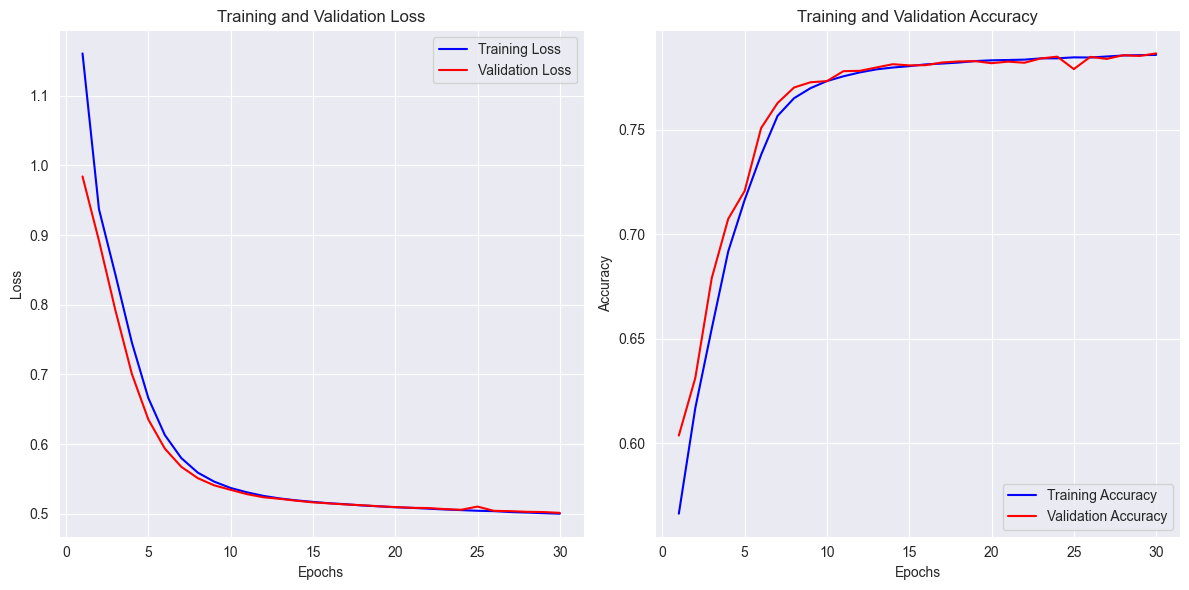

In [198]:
# Access the loss, validation loss, and accuracy from the history object
loss = history_embed.history['loss']
val_loss = history_embed.history['val_loss']
accuracy = history_embed.history['categorical_accuracy']
val_accuracy = history_embed.history['val_categorical_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Inference

In [199]:
def decode_one_hot(one_hot, charges = [1,2,3,4,5,6]):
    for index, hot in enumerate(one_hot):
        if hot == 1:
            return charges[index]

In [200]:
def predictions_no_hot(one_hot, charges = [1,2,3,4,5,6]):
    index = np.argmax(one_hot)
    return(charges[index])

In [201]:
np.argmax([0, 0 ,0 ,0, 1])

4

In [226]:
# test predict for one
for index, row in test_df.iterrows():
    solut1 = np.expand_dims(tf.convert_to_tensor(np.array(test_df.at[index, "modified_sequence_vector"])), axis=0)
    test_give = model_embed.predict(solut1, verbose=False)
    break
print(test_give[0])

[1.2747392e-01 8.6265469e-01 9.8505383e-03 2.0754635e-05 1.9375770e-08
 2.6272868e-09]


In [202]:
test_df = pd.DataFrame(columns=['modified_sequence_vector', 'true_label', 'pred_label'])
# every row of tensor to list
test_df['modified_sequence_vector'] = test_ds_embed.numpy().tolist()
test_df['true_label'] = test_labels_embed.numpy().tolist()
test_df['pred_label'] = None
test_df['true_label'] = test_df['true_label'].apply(decode_one_hot)

In [203]:
# PREDICT
for index, row in test_df.iterrows():
    solut = np.expand_dims(tf.convert_to_tensor(test_df.at[index, "modified_sequence_vector"]), axis=0)
    test_df.at[index, 'prediction'] = model_embed.predict(solut, verbose=False)

In [223]:
test_df['pred_label'] = test_df['prediction'].apply(predictions_no_hot)

In [235]:
test_df.head(4)

,modified_sequence_vector,true_label,pred_label,prediction
0,"[4, 18, 1, 1, 1, 15, 1, 1, 4, 17, 4, 0, 0, 0, ...",2,2,"[0.12747392, 0.8626547, 0.009850538, 2.0754635..."
1,"[16, 12, 16, 10, 15, 10, 16, 10, 8, 6, 3, 15, ...",2,2,"[0.00020726993, 0.5206397, 0.476445, 0.0027061..."
2,"[4, 22, 10, 17, 15, 1, 8, 9, 17, 14, 10, 18, 1...",3,3,"[3.4061266e-06, 0.25153342, 0.7321024, 0.01633..."
3,"[8, 13, 15, 18, 17, 17, 13, 10, 16, 16, 10, 0,...",2,2,"[0.043792143, 0.93763536, 0.018512432, 6.00232..."


In [238]:
# iterate all rows of grouped_df_embed
size_of_df = test_df.shape[0]
true_counter = 0
for index, row in test_df.iterrows():
    if row['true_label'] == row['pred_label']:
        true_counter += 1

print(true_counter/size_of_df, true_counter, size_of_df)

0.7874389157699622 65422 83082


In [239]:
1 / np.log10(6) # TODO sanity check, look into formula

1.2850972089384687

[[ 2759  1364     3     0     0     0]
 [  580 37685  6950   109     4     0]
 [    6  3740 20827  1436    30     1]
 [    0    81  2459  3822   139     2]
 [    0     4    26   549   312    12]
 [    0     0    14    54    97    17]]
Accuracy:  0.7874389157699622
Precision:  0.7931974691922175
Recall:  0.7874389157699622
F1:  0.7875832467871225


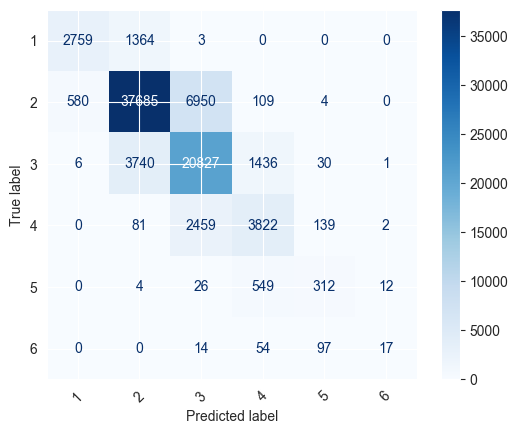

In [240]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sn

true_labels = test_df['true_label']
predicted_labels = test_df['pred_label']

cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
print("Accuracy: ", accuracy_score(true_labels, predicted_labels))
# TODO calculate for score for each class (and/or average)
# TODO lookup logic for weighted, macro etc. -> presentation
print("Precision: ", precision_score(true_labels, predicted_labels, average='weighted'))
print("Recall: ", recall_score(true_labels, predicted_labels, average='weighted'))
print("F1: ", f1_score(true_labels, predicted_labels, average='weighted'))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

#sn.heatmap(cm2, annot=True, cmap="crest")
# TODO  check if most abundant is chosen

In [241]:
from sklearn.metrics import confusion_matrix

new_df = pd.DataFrame(columns=['charge','accuracy'])

matrix = confusion_matrix(true_labels, predicted_labels)
new_df['charge'] = [1,2,3,4,5,6]
new_df['accuracy'] = matrix.diagonal()/matrix.sum(axis=1)


In [242]:
new_df

,charge,accuracy
0,1,0.668686
1,2,0.831385
2,3,0.799808
3,4,0.587729
4,5,0.345515
5,6,0.093407


# Outputs to compare with prosit

In [247]:
np.array(train_ds_embed).tofile('comparison_files/train_ds_embed.tsv', sep="\t")
np.array(train_labels_embed).tofile('comparison_files/train_labels_embed.tsv', sep="\t")
np.array(val_ds_embed).tofile('comparison_files/val_ds_embed.tsv', sep="\t")
np.array(val_labels_embed).tofile('comparison_files/val_labels_embed.tsv', sep="\t")
np.array(test_ds_embed).tofile('comparison_files/test_ds_embed.tsv', sep="\t")
np.array(test_labels_embed).tofile('comparison_files/test_labels_embed.tsv', sep="\t")

# IGNORE FROM HERE

## Check in with Franzi's group for reporting

### Multilable Model
#### WIP in precursor_charge_predictor

## Model Testing
### check if models only predict charge 2 or also other charges. Due to 'overrepresentation' the best bet for the model could be to only output charge state 2

## Hyperparameter Tuning

# Inference

In [35]:
batches_parquet[file_list[1]]["precursor_charge"].value_counts()

2    1401912
3     787278
4     220159
5      34381
1      26371
6       4417
Name: precursor_charge, dtype: int64

In [36]:
last_model = keras.models.load_model('precursor_charge_prediction_model_cce_alpha/cce_wo7_allSequences.h5')

OSError: No file or directory found at precursor_charge_prediction_model_cce_alpha/cce_wo7_allSequences.h5

In [ ]:
batches_parquet.keys()

In [ ]:
# Make validation data
inference_df = batches_parquet[file_list[1]][["precursor_charge", "modified_sequence_vector", "precursor_intensity"]].copy()

In [ ]:
inference_df.head(4)

In [ ]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

In [ ]:
inference_df = inference_df[inference_df['modified_sequence_vector'].apply(lambda x: len(x) <= 50)]

In [37]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

NameError: name 'inference_df' is not defined

In [ ]:
[i for i in inference_df["precursor_charge"] if i not in [2,3,4]]

In [ ]:
[i for i in inference_df["precursor_intensity"] if i > 1000000000000]

In [ ]:
inference_df

In [38]:
inference_df[list(range(0, 50))] = pd.DataFrame(inference_df["modified_sequence_vector"].tolist(), index= inference_df.index)

NameError: name 'inference_df' is not defined

In [ ]:
inference_df.drop("modified_sequence_vector", axis=1, inplace=True)

In [ ]:
inference_df.head(4)

In [ ]:
inference_ds = tf.convert_to_tensor(inference_df)

In [ ]:
inference_target = inference_ds[:, 0]
inference_features = inference_ds[:, 1:]

In [ ]:
inference_target_labels =  np.array([one_hot_precursor(i, charges=charge_ranges) for i in inference_target])

In [ ]:
results = model_cce.evaluate(inference_features, inference_target_labels, batch_size=256)
print("test loss, test acc:", results)

## Evaluate the models
- confusion matrix
- accuracy
- loss

Confusion Matrix

In [39]:
import sklearn
matrix = sklearn.metrics.confusion_matrix(train_ds_labels.argmax(axis=1), inference_target_labels.argmax(axis=1))

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
#!pip install scikit-learn
#!pip install numpy --upgrade
#!pip install pandas --upgrade
#!pip install matplotlib --upgrade
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
#do_predictions = model.predict(test_ds)

y_pred = []
y_true = []

# iterate over the dataset
for index, i in enumerate(inference_ds):   # use dataset.unbatch() with repeat
   print(inference_target_labels[index])
   print(inference_features[index])
   # append true labels
   y_true.append(inference_target_labels[index])
   # compute predictions
   preds = model_cce.predict(inference_features[index])
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1))
# convert the true and predicted labels into tensors
true_labels = tf.cast(tf.concat([item for item in y_true], axis = 0), tf.float32)
predicted_labels = tf.cast(tf.concat([item for item in y_pred], axis = 0), tf.float32)


cm = confusion_matrix(true_labels, predicted_labels)
#print(cm)
report = classification_report(true_labels,predicted_labels, target_names=class_names)

report_dict = classification_report(true_labels, predicted_labels, output_dict=True)
#print(report_dict)
print(report)

#pd.DataFrame(report_dict).transpose()


Accuracy/ Sens/ Spec

In [40]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    #print(y_pred.shape, y_true.shape)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(K.cast(y_pos * y_pred_pos, 'float32'))
    tn = K.sum(K.cast(y_neg * y_pred_neg, 'float32'))
    fp = K.sum(K.cast(y_neg * y_pred_pos, 'float32'))
    fn = K.sum(K.cast(y_pos * y_pred_neg, 'float32'))

    print("OVERALL:")
    print(" Accuracy ", ((tp + tn) / (tp + tn + fp + fn)).numpy())
    print(" Sensitivity ", (tp / (tp + fn)).numpy())
    print(" Specificity ", (tn / (tn + fp)).numpy())

    numerator = (tp * tn - fp * fn)
    #print(tp.numpy(), fp.numpy())
    test = (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    #print(test)
    denominator = K.sqrt(K.cast(test, 'float32'))

    return numerator / (denominator + K.epsilon())


#print(true_labels, predicted_labels)
print(" matthews_correlation(rounded): ", (matthews_correlation(true_labels, predicted_labels).numpy()))

NameError: name 'true_labels' is not defined

MCC

In [41]:
from sklearn.metrics import matthews_corrcoef

print("matthews_correlation:", matthews_corrcoef(true_labels, predicted_labels))

NameError: name 'true_labels' is not defined

Direct eval:

In [42]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

eval_prec = Precision()
eval_rec = Recall()
eval_acc = BinaryAccuracy()

In [43]:
for batch in test_ds.as_numpy_iterator():
    X, y = batch
    y = tf.keras.utils.to_categorical(y, num_classes=13, dtype='int')
    yhat = model.predict(X)
    eval_prec.update_state(y, yhat)
    eval_rec.update_state(y, yhat)
    eval_acc.update_state(y, yhat)

NameError: name 'test_ds' is not defined

In [ ]:
print(f'Precision: {eval_prec.result().numpy()}, Recall: {eval_rec.result().numpy()}, Accuracy: {eval_acc.result().numpy()}')